# Theoretical fuel burn per route 

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from cmcrameri import cm as scm
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from tqdm import tqdm

In [2]:
pd.set_option('display.max_rows', None)

In [24]:
pd.reset_option('display.max_rows')

In [3]:
# load data
raw = pd.read_csv("../../raw/emissionV22_2025-02-24.csv")

## 1. List of unique airlines

In [25]:
airlines = raw["airlineiatacode"].unique()
airlines

array(['U2', 'SK', 'BT', 'Y4', 'VB', 'SN', 'ME', 'EK', 'WG', 'AW', 'ET',
       'VW', 'WF', 'UA', '2J', 'HF', 'QR', 'AM', 'KL', 'TS', 'MS', 'KQ',
       'KP', 'TK', 'SA', 'BA', 'AF', 'AT', 'DL', 'OP', 'TP', 'IB', 'WB',
       'P4', 'VY', 'LS', 'UX', 'TB', 'FR', 'KN', '8L', 'GY', 'MU', '6B',
       'EW', 'HV', 'OR', 'V7', 'BY', 'XR', 'AY', 'NT', 'TO', 'WK', 'DE',
       'DK', 'X3', 'EI', '4Y', 'LG', 'NO', 'W6', 'RK', 'DY', 'PM', 'QS',
       'EU', 'G5', 'GS', 'CZ', 'B6', 'XP', 'XC', 'XQ', 'GJ', 'PE', 'AA',
       'IR', 'SY', '3U', 'AQ', 'NK', 'PC', 'IO', 'W5', 'A3', 'ZF', 'JU',
       'FZ', 'J2', 'KU', 'SV', 'IY', 'DJ', 'J4', 'RJ', 'AS', 'NZ', 'VA',
       'QF', 'JQ', 'P5', 'LA', 'HU', 'VH', 'JD', 'ZL', 'MH', 'CX', 'SQ',
       'QQ', 'ZP', 'FJ', 'AR', 'FO', 'WJ', 'EP', 'CM', 'AV', 'Q4', 'G3',
       'U6', 'Y7', 'N4', 'EO', 'A4', 'SU', 'RT', '5N', '3F', 'G6', 'S7',
       'JA', 'H2', 'D2', 'WZ', 'I8', 'R3', 'UT', 'HY', 'B2', 'YC', '4G',
       'DV', 'D8', 'AD', 'FI', '3O', 'W9', 'TF', 'G

## 2. Create list of aircrafts, IATA code and let Claude fill in average fuel burn

In [26]:
dfa = pd.DataFrame(columns=["IATA code", "Aircraft name", "Average Fuel Burn [kg/hour]"])

aircrafts = raw["aircraftiatacode"].unique()
for aircraft in aircrafts:
    name = raw[raw["aircraftiatacode"] == aircraft]["aircraftname"].iloc[0]
    
    new_row = pd.DataFrame({"IATA code": [aircraft], 
                            "Aircraft name": [name],
                            "Average Fuel Burn [kg/hour]": [''],
                            })
    dfa = pd.concat([dfa, new_row], ignore_index=True)

# don't overwrite file that Claude already filled in with fuel burn values
# dfa.sort_values(by='IATA code').to_csv("aircraft_fuel_burn.csv", index=False)

In [27]:
df_fuel_burn = pd.read_csv("../open_data/aircraft_fuel_burn.csv")
df_fuel_burn

,IATA code,Aircraft name,Average Fuel Burn [kg/hour]
0,100,Fokker 100,2000.0
1,142,BAe 146-200 Passenger,2200.0
2,146,BAe 146 Passenger,2500.0
3,221,Airbus A220-100 Passenger,1700.0
4,223,Airbus A220-300 Passenger,1800.0
...,...,...,...
111,S20,Saab 2000,700.0
112,SF3,Saab 340,600.0
113,SFB,Saab 340B,620.0
114,SU9,Sukhoi Superjet 100-95,1800.0


# 3. Outermost loop over airlines

In [60]:
new = pd.DataFrame()

for airline in airlines:
    name = raw[raw["airlineiatacode"] == airline]["airlinename"].iloc[0]
    flights = raw[raw["airlineiatacode"] == airline]

    # unique list of departures within airline
    departures = flights["emissionflightinfo_departureiatacode"].unique()

    for departure in departures:
        flights_dep = flights[flights["emissionflightinfo_departureiatacode"] == departure]

        # unique list of arrivals within departures
        arrivals = flights_dep["emissionflightinfo_arrivaliatacode"].unique()

        for arrival in arrivals:
            
            aircrafts = flights_dep[flights_dep["emissionflightinfo_arrivaliatacode"] == arrival]
            n_aircrafts = len(aircrafts)

            total_fuel_burn = 0
            total_seats = 0

            for aircraft, seats, frequency in zip(aircrafts["aircraftiatacode"], aircrafts["seatcount"], aircrafts["frequency"]):
            
                fuel_burn = np.float32(df_fuel_burn[df_fuel_burn['IATA code'] == aircraft]["Average Fuel Burn [kg/hour]"].iloc[0])
                total_fuel_burn += fuel_burn*frequency
                total_seats += seats*frequency

            fuel_burn_per_seat = total_fuel_burn/total_seats
            
            aircrafts_str = '; '.join([aircraft for aircraft in aircrafts["aircraftiatacode"]])
            
            new_row = pd.DataFrame({"Airline": [airline],
                                    "Airline name": [name],
                                    "Departure": [departure],
                                    "Arrival": [arrival],
                                    "Aircrafts": [aircrafts_str],
                                    "Fuel burn [kg/hour/seat]": [fuel_burn_per_seat],
                                   })
            new = pd.concat([new, new_row], ignore_index=True)

new.to_csv("../data/by_route_fuel_burn.csv", index=False)

In [61]:
new

,Airline,Airline name,Departure,Arrival,Aircrafts,Fuel burn [kg/hour/seat]
0,U2,Easyjet,ABZ,LTN,319; 320,15.542035
1,U2,Easyjet,ABZ,GVA,320,13.978495
2,U2,Easyjet,ABZ,LGW,319; 320,15.872722
3,U2,Easyjet,ACE,BER,320,14.207650
4,U2,Easyjet,ACE,AMS,320,13.978495
...,...,...,...,...,...,...
81839,8T,Air Tindi Ltd,YZF,YSG,DH2,26.315790
81840,N5,Nolinor Aviation,YMX,YVO,737,20.168068
81841,N5,Nolinor Aviation,YVO,YMX,737,20.168068
81842,9M,Central Mountain Air Ltd.,YVR,YYD,DH1,12.162162


# 4. Sort by_route_airline.csv

In [62]:
df2 = pd.read_csv("../data/by_route_airline.csv")
df2["idx"] = np.zeros(len(df2), dtype=int)
df2

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,rpk,average_load,co2,gco2_pax_km,idx
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,2.515524e+09,0.814869,191365.676340,76.073891,0
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,2.480272e+09,0.814869,195266.817616,78.727996,0
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,8.936213e+08,0.839453,100145.929946,112.067534,0
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,8.619707e+08,0.839453,96146.969851,111.543198,0
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,1.678008e+09,0.700556,161111.234068,96.013360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,OSL,BOO,14.365300,67.269203,11.100400,60.193901,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,2.278307e+04,0.646481,3.184374,139.769276,0
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,2.302834e+04,0.785064,3.052329,132.546626,0
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,2.302834e+04,0.785064,3.052329,132.546626,0
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,1.910700e+04,0.703706,2.493229,130.487717,0


In [68]:
for row_index in tqdm(range(len(df2))):
    dep = df2["departure"].iloc[row_index]
    arr = df2["arrival"].iloc[row_index]
    name = df2["airlinename"].iloc[row_index]

    w = (new["Departure"] == dep) & (new["Arrival"] == arr) & (new["Airline name"] == name)
    n = sum(w)
    if n == 1:
        idx = w[w == True].index[0]
    elif n == 0:
        idx = 0
    else:
        idx = -1
    
    df2.loc[row_index, "idx"] = idx

100%|█████████████████████████████████████| 81844/81844 [18:27<00:00, 73.90it/s]


In [70]:
df2 = df2.sort_values("idx")

In [72]:
df2["fuel_burn"] = new["Fuel burn [kg/hour/seat]"]
df2

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,rpk,average_load,co2,gco2_pax_km,idx,fuel_burn
22491,ABZ,LTN,-0.368333,51.874699,-2.197780,57.201900,Easyjet,2,704.642441,212097.374774,181997.374774,301,44357.976812,48816,3.125651e+07,0.908677,3002.609769,96.063491,0,14.431673
76483,ABZ,GVA,6.108950,46.238098,-2.197780,57.201900,Easyjet,1,1445.993886,11567.951085,10767.951085,8,1352.111388,1488,1.955145e+06,0.908677,138.997051,71.092970,1,14.054054
10679,ABZ,LGW,-0.190278,51.148102,-2.197780,57.201900,Easyjet,2,786.430229,483654.591061,422154.591061,615,88241.624226,97110,6.939588e+07,0.908677,6598.559818,95.085756,2,15.723270
66787,ACE,BER,13.500672,52.362247,-13.605200,28.945499,Easyjet,1,3528.958906,84695.013743,82295.013743,24,3990.909418,4392,1.408376e+07,0.908677,890.172346,63.205610,3,12.558140
64925,ACE,AMS,4.763890,52.308601,-13.605200,28.945499,Easyjet,1,3109.370578,83953.005610,81253.005610,27,4563.375933,5022,1.418923e+07,0.908677,890.314645,62.745818,4,16.774193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77440,YZF,YSG,-110.681999,62.418304,-114.440002,62.462799,Air Tindi Ltd,1,243.596030,18756.894297,14906.894297,77,1148.548823,1463,2.797819e+05,0.785064,87.634275,313.223496,81839,11.111111
41030,YMX,YVO,-77.782799,48.053299,-74.038696,45.679501,Nolinor Aviation,1,438.556458,83325.726966,73825.726966,190,17750.299988,22610,7.784509e+06,0.785064,1285.121719,165.087069,81840,20.536379
41029,YVO,YMX,-74.038696,45.679501,-77.782799,48.053299,Nolinor Aviation,1,438.556458,83325.726966,73825.726966,190,17750.299988,22610,7.784509e+06,0.785064,1285.121719,165.087069,81841,16.037735
78850,YVR,YYD,-127.182999,54.824699,-123.183998,49.193901,Central Mountain Air Ltd.,1,783.845438,20379.981386,17779.981386,26,755.231693,962,5.919849e+05,0.785064,75.523169,127.576171,81842,16.911764


In [74]:
df2.to_csv("../data/by_route_airline_fuel_burn.csv", index=False)

In [79]:
fb = df2["fuel_burn"].values

(array([5.8000e+01, 2.4900e+02, 2.2000e+01, 6.8300e+02, 4.6400e+02,
        9.1200e+02, 1.2130e+03, 2.0540e+03, 3.0200e+03, 3.3180e+03,
        1.2474e+04, 8.3220e+03, 1.1217e+04, 7.0290e+03, 6.1060e+03,
        4.9140e+03, 3.3760e+03, 2.8350e+03, 2.3470e+03, 1.5520e+03,
        2.7000e+03, 1.5850e+03, 1.2040e+03, 7.8700e+02, 5.9300e+02,
        4.9300e+02, 3.9100e+02, 4.8900e+02, 2.9400e+02, 1.6400e+02,
        2.0000e+02, 9.9000e+01, 5.7000e+01, 8.5000e+01, 2.6500e+02,
        3.1000e+01, 1.6000e+01, 3.0000e+01, 2.4000e+01, 2.0000e+01,
        4.0000e+01, 0.0000e+00, 1.2000e+01, 4.0000e+01, 0.0000e+00,
        4.0000e+00, 4.0000e+00, 1.6000e+01, 0.0000e+00, 0.0000e+00,
        8.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.0000e+00, 0.0000e+00, 1.6000e+01]),
 array([ 6.97674417,  7.58963156,  8.20251942,  8.8154068 ,  9.42829418,
        10.04118156, 10.6540699 , 11.26695728, 11.87984467, 12.49273205,
        13.10561943, 13.71850777, 14

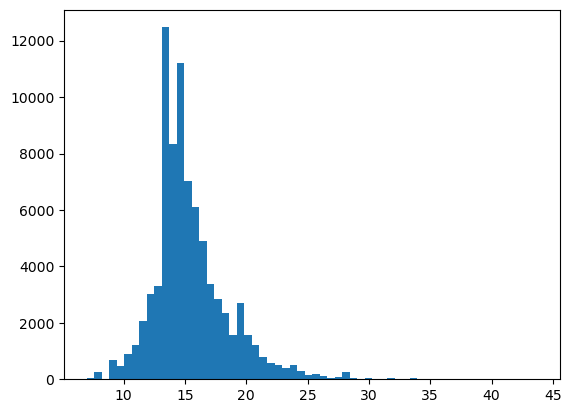

In [82]:
plt.hist(fb, bins=60)